# 하이퍼 파라미터 튜닝

`keras-tuner` 패키지의 설치가 필요하다.

```shell
pip install --upgrade keras-tuner
```

## #01. 준비작업

### [1] 패키지 가져오기


In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from helper.util import *
from helper.plot import *
from helper.tensor import *

from datetime import datetime as dt
from kerastuner import Hyperband

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import (
    History,
    EarlyStopping,
    ReduceLROnPlateau,
)

from tensorflow.keras.optimizers import Adam

from tensorflow.random import set_seed
from tensorflow.keras.initializers import GlorotUniform

set_seed(get_random_state())
__initializer__ = GlorotUniform(seed=get_random_state())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터셋 준비하기


In [2]:
origin = my_read_excel("https://data.hossam.kr/mldata/fish.xlsx", info=False)

## #02. 데이터 전처리

### [1] 데이터 스케일링


In [3]:
df = my_minmax_scaler(data=origin, yname="무게")

my_pretty_table(data=df.head())

+----+----------+----------+-----------+--------+
|    |     길이 |     높이 |      두께 |   무게 |
|----+----------+----------+-----------+--------|
|  0 |        0 |        0 |         0 |    5.9 |
|  1 | 0.148876 | 0.132834 | 0.0876672 |     32 |
|  2 | 0.185393 | 0.159963 |   0.15156 |     40 |
|  3 | 0.219101 | 0.231993 |  0.181278 |   51.5 |
|  4 | 0.252809 | 0.231993 |   0.22734 |     70 |
+----+----------+----------+-----------+--------+


### [2] 훈련/검증 데이터 분할


In [4]:
x_train, x_test, y_train, y_test = my_train_test_split(df, "무게")
rows, cols = x_train.shape

## #03. 하이퍼파라미터 튜닝

### [1] 훈련 모델 적합

컴파일이 완료된 텐서플로우 Sequential 객체가 필요하다.


In [5]:
def tf_build(hp) -> Sequential:
    # print(type(hp))
    model = Sequential()

    model.add(
        Dense(
            units=hp.Choice("units", values=[32, 64, 128]),
            activation="relu",
            input_shape=(cols,),
        )
    )
    model.add(
        Dense(
            units=hp.Choice("units", values=[16, 32, 64]),
            activation="relu",
        )
    )
    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
        loss="mse",
        metrics=["mae"],
    )

    return model

### [2] 튜너를 인스턴스화하고 하이퍼튜닝 수행하기

튜너를 인스턴스화하여 하이퍼튜닝을 수행한다.

Keras Tuner에는 RandomSearch, Hyperband, BayesianOptimization 및 Sklearn의 네 가지 튜너가 있다.

Hyperband 튜너를 인스턴스화하려면 최적화할 하이퍼모델인 objective, 및 훈련할 최대 epoch 수(max_epochs)를 지정해야 한다.

Hyperband 튜닝 알고리즘은 적응형 리소스 할당 및 조기 중단을 사용하여 고성능 모델에서 신속하게 수렴합니다. 

이 알고리즘은 몇 개의 epoch에 대해 많은 수의 모델을 훈련하고 최고 성능을 보이는 절반만 다음 단계로 넘긴다.

Hyperband는 `1 + logfactor( max_epochs)` 를 계산하고 이를 가장 가까운 정수로 반올림하여 한 브래킷에서 훈련할 모델 수를 결정한다.

> Li, Lisha, and Kevin Jamieson. ["Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization." Journal of Machine Learning Research 18 (2018): 1-52](http://jmlr.org/papers/v18/16-558.html)


In [6]:
tuner = Hyperband(
    hypermodel=tf_build, # 하이퍼파라미터를 튜닝하기 위한 모델 생성 함수
    objective="val_mae", # 최적화 기준값
    max_epochs=10,     
    factor=3,
    seed=get_random_state(),
    directory="D:\\tensor_hyperband",
    project_name="tf_hyperband_%s" % dt.now().strftime("%Y%m%d%H%M%S"),
)

tuner

In [7]:
tuner.search(
    x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test)
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()

if not best_hps:
    raise ValueError("No best hyperparameters found.")

print(
    f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps[0].get('units')} and the optimal learning rate for the optimizer
is {best_hps[0].get('learning_rate')}.
"""
)

Trial 9 Complete [00h 00m 01s]
val_mae: 348.3740234375

Best val_mae So Far: 345.9520568847656
Total elapsed time: 00h 00m 15s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128 and the optimal learning rate for the optimizer
is 0.01.



### [3] 학습 결과 평가

도출된 하이퍼 파라미터가 적용된 새로운 모듈을 생성하고 학습을 다시 진행해야한다.


+-------+---------+---------+
|       |    loss |     mae |
|-------+---------+---------|
| train | 57804.5 | 214.807 |
| test  | 28260.8 | 163.747 |
+-------+---------+---------+


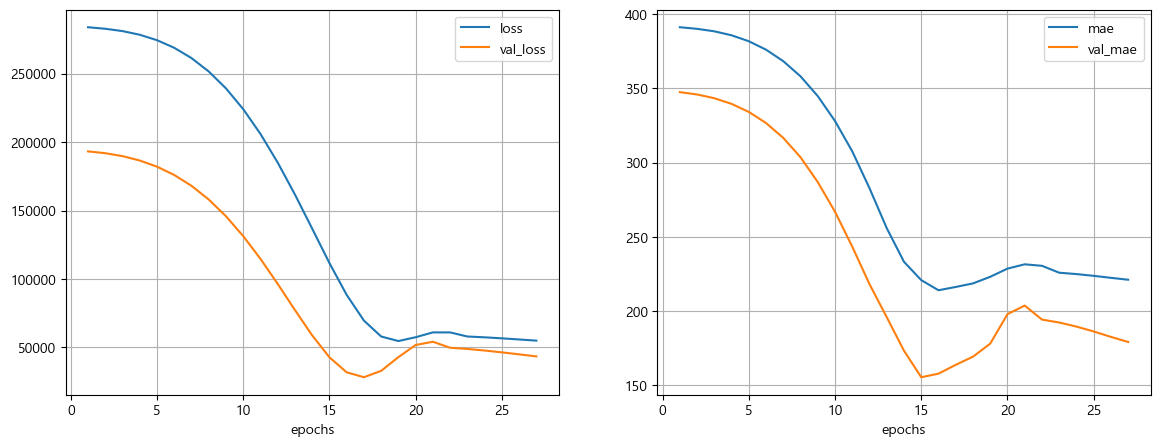

In [8]:
model = tuner.hypermodel.build(best_hps[0])
result = tf_train(model, x_train, y_train, x_test, y_test)
tf_result(result)